# Initialize databank

In [1]:
import sys
import seaborn as sns

sys.path.insert(1, '../../Databank/Scripts/BuildDatabank/')
from databankLibrary import * #download_link, lipids_dict, databank

path = '../Data/MD-PERMEATION/'
db_data = databank(path)
systems = db_data.get_systems()

Databank initialized from the folder: /home/sosamuli/work/NMRlipids/DataBankManuscript/Data/MD-PERMEATION


# Define functions

In [2]:
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
import seaborn as sn
import os
import scipy.stats
from scipy import stats
import scipy.optimize
import math

def getBoxZ(system):
    path = system['path']
    BoxZpath = '../Data/BoxZ/' + path
    BoxZpath = BoxZpath + 'BoxZ.json'
    #try:
    f = open(BoxZpath)
    BoxZdata = json.load(f)
    sumBoxZ = 0
    sumIND = 0
    for i,j in BoxZdata.items():
        sumBoxZ += j
        sumIND += 1
    BoxZ = sumBoxZ/sumIND
    return(BoxZ)


def chargedFraction(system):
    Nlipid = 0
    for molecule in system['COMPOSITION']:
        if molecule in lipids_dict:
            Nlipid += np.sum(system['COMPOSITION'][molecule]['COUNT'])
    
    Ncharged = 0
    chargedlipids = ['POPG', 'POPS', 'DPPG', 'DOPS', 'POPI', 'SAPI', 'SLPI', 'DHMDMAB']
    for molecule in system['COMPOSITION']:
        if molecule in chargedlipids:
            Ncharged += np.sum(system['COMPOSITION'][molecule]['COUNT'])
            
    return Ncharged/Nlipid

def getWaterPermeationRate(system):
    path = system['path']
    with open('../Data/MD-PERMEATION/' + path + 'Counting_events.txt', 'r') as f:
        last_line = f.readlines()[-1]
    last_line = last_line.split()
    time = float(last_line[0])
    count = float(last_line[1])
    area = calcArea(system)
    #rate = count / (time * area)  #1/(ns*Å^2)
    rate = count / (time)  #1/ns
    #thickness = GetThickness(system)*10
    #Nwater = system['COMPOSITION']['SOL']['COUNT']
    print(rate, area)
    P = 0.5*rate*10**9/(area*10**-20 * 33.3679*10**27)
    return P*10**6  # micrometer per second

def getWaterDiffusionThroughMembrane(system):
    thickness = GetThickness(system)
    
    LateralDiffusion = getWaterLateralDiffusion(system)*10**-9 #m^2/s
    Permeation = getWaterPermeationRate(system)*10**-6 #m/s
    WaterThickness = (getBoxZ(system) - thickness)*10**-10 #m
    
    D = LateralDiffusion*Permeation*WaterThickness/(LateralDiffusion + Permeation * WaterThickness)
    return D*10**9 # 10^-9 m^2/s
    #D= 0.5*rate*10**9*(thickness*10**-9)**2 # m²/s
    #return D*10**4*10**5 # (10^-5 * cm^2)/s

def getWaterLateralDiffusion(system):
    path = system['path']
    waterDIFFUSIONpath = '../Data/WATERdiffusion/' + path
    waterDIFFUSIONpath = waterDIFFUSIONpath + 'WATERlateralMSD.xvg'
    D = float(os.popen('grep D ' + waterDIFFUSIONpath + " | grep = | awk '{print $5}'").read())
    return D # 10^-9 m^2/s
    
def plotCorrelation(xProperty,yProperty,permeationResults):
    xPropertyData = []
    yPropertyData = []
    for ID in permeationResults:
        xPropertyData.append(permeationResults[ID][xProperty])
        yPropertyData.append(permeationResults[ID][yProperty])
    plt.plot(xPropertyData,yPropertyData,'.')
    
def plotXaveragedData(xProperty,yProperty,permeationResults,rounddec,MinimumDataLength):
    avetemp = {}
    for ID in permeationResults:
        #print(permeationVStemperature[ID])
        temperature = rounddec * round(permeationResults[ID][xProperty] / rounddec) # round(permeationVStemperature[ID][xProperty], rounddec)
        if temperature not in avetemp.keys():
            avetemp[temperature] = {}
            avetemp[temperature]['values'] = []
            avetemp[temperature]['weigths'] = []
        avetemp[temperature]['values'].append(permeationVStemperature[ID][yProperty])
        avetemp[temperature]['weigths'].append(permeationVStemperature[ID]['SimLenght']) 
        #print(permeationVStemperature[ID]['permeation'], permeationVStemperature[ID]['temperature'])
    
    xPropertyData = []
    yPropertyData = []
    yPropertyDataError = []
    for temp in avetemp:
        #if len(avetemp[temp]['values']) < 3:
        #    continue
        if np.sum(avetemp[temp]['weigths']) < MinimumDataLength:
            continue
        average = np.average(avetemp[temp]['values'], weights = avetemp[temp]['weigths'])
        variance = np.average((avetemp[temp]['values']-average)**2, weights = avetemp[temp]['weigths'])
        xPropertyData.append(temp)
        yPropertyData.append(average)
        yPropertyDataError.append(math.sqrt(variance)/math.sqrt(len(avetemp[temp]['values'])))
        #yPropertyDataError.append(math.sqrt(variance))
    #print(yPropertyDataError)
    plt.errorbar(xPropertyData,yPropertyData, yerr=yPropertyDataError, marker = ".", linestyle='', markersize =15, color = 'black')
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.ylabel('P (\u03bcm/s)', fontsize = 18)
    #plt.show()
    #plt.errorbar(result[0],result[1], yerr=result[2], marker = ".", linestyle='')
    return xPropertyData,yPropertyData,yPropertyDataError     


# Create dictionary containing the data under interest

In [3]:
permeationVStemperature = {}
ID = 0
for system in systems:
    path = system['path']
    
    #DPPCFraction = calcLipidFraction(system, 'DSPC')
    #if DPPCFraction != 1:
    #    continue
    
    #if 'CLA' in system['COMPOSITION'].keys() and system['COMPOSITION']['CLA']['COUNT'] > 0:
    #    continue
    
    
    try:
        rate = getWaterPermeationRate(system)
        print(rate)
    except:
        #print('Water permeation failed, setting rate to 0: ' + path)
        rate = 0
        #continue
    
    if rate == 0:
        continue
    
    #if system['TEMPERATURE'] < 320:
    #    print(system['TEMPERATURE'], path)
    
    
    WaterLateralDiffusion = getWaterLateralDiffusion(system)
    
    #if WaterLateralDiffusion > 15:
    #    print(path)
    #    print('Water diffusion larger than 15: ', WaterLateralDiffusion)
    #    continue
    
    DiffThroughMem = getWaterDiffusionThroughMembrane(system)
    #print(DiffThroughMem, WaterLateralDiffusion)
    DiffAniso = DiffThroughMem / WaterLateralDiffusion
    
    #if rate > 0:
    PermeationDiffusionRatio = rate/WaterLateralDiffusion
    #else:
    #    PermeationDiffusionRatio = 'nan'
    
    APL = CalcAreaPerMolecule(system)
    
    try:
        thickness = GetThickness(system)
    except:
        thickness = 0 #float('nan')

    #if thickness < 3:
    #    continue
        
    area = calcArea(system)   
    
    tailOPavg = -np.average(averageOrderParameters(system))
    #print(tailOPavg)
    if str(tailOPavg) == 'nan':
        print(system)
    
    sn1OPavg = -averageOrderParameters(system)[0]
    sn2OPavg = -averageOrderParameters(system)[1]
    
    hydration = getHydrationLevel(system)
    
    CholFraction = calcLipidFraction(system, 'CHOL')
    
    POPGFraction = calcLipidFraction(system, 'POPG')
    
    POPSFraction = calcLipidFraction(system, 'POPS')
    
    POPEFraction = calcLipidFraction(system, 'POPE')
    
    ChargedFraction = chargedFraction(system)
    
    temperature = system['TEMPERATURE']
    
    #if temperature > 315 or temperature < 300:
    #    continue
    
    SimLength = system['TRJLENGTH'] - system['PREEQTIME']
    
    try:
        ForceField = system['FF']
    except:
        ForceField = 'Unknown'
    
    if thickness == 0:
        continue
    
    ID += 1
    permeationVStemperature[ID] = {
        'path': path, 
        'permeation': rate, 
        'WaterLateralDiffusion' : WaterLateralDiffusion,
        'DiffThroughMem' : DiffThroughMem,
        'DiffAniso' : DiffAniso,
        'APL': float(APL), 
        'volume': APL*thickness,
        'thickness': thickness,
        'TailOrder' : float(tailOPavg),
        #'sn1Order' : sn1OPavg,
        #'sn2Order' : sn2OPavg,
        'hydration': float(hydration),
        'temperature': temperature ,
        'ChargedFraction': float(ChargedFraction),
        'CholFraction': float(CholFraction),
        'POPGFraction': float(POPGFraction),
        'POPSFraction': float(POPSFraction),
        'POPEFraction': float(POPEFraction),
        #'DSPCFraction': float(DPPCFraction),
        'ForceField': ForceField,
        'SimLenght': SimLength,
        'PermeationDiffusionRatio' : PermeationDiffusionRatio,
        'area' : float(area),
    }

128 64.32150526249865
0.024002399663908797 4116.576336799913
8.736945339435065
128 64.32150526249865
0.024002399663908797 4116.576336799913
128 64.32150526249865
200 63.952694558595894
0.05541701394431168 6395.2694558595895
12.984505128740048
200 63.952694558595894
0.05541701394431168 6395.2694558595895
200 63.952694558595894
286 48.895333433313404
0.026005201352332884 6992.032680963816
5.573113659524628
286 48.895333433313404
0.026005201352332884 6992.032680963816
286 48.895333433313404
200 48.01659178650021
0.001250156232024316 4801.65917865002
0.3901342587634684
200 48.01659178650021
0.001250156232024316 4801.65917865002
200 48.01659178650021
1664 42.259913864402805
0.015555555555555555 35160.24833518313
0.6629407594169999
1664 42.259913864402805
0.015555555555555555 35160.24833518313
1664 42.259913864402805
128 65.51710377378144
0.020010005623121736 4193.094641522012
7.150784248414929
128 65.51710377378144
0.020010005623121736 4193.094641522012
128 65.51710377378144
500 54.35268291

128 64.16556389451058
0.005065958886015094 4106.596089248677
128 64.16556389451058
200 59.408362721263046
0.030030029579128686 5940.836272126305
7.574418648545114
200 59.408362721263046
0.030030029579128686 5940.836272126305
200 59.408362721263046
212 55.03932705564947
0.020002000640108025 5834.168667898844
5.137307778562109
212 55.03932705564947
0.020002000640108025 5834.168667898844
212 55.03932705564947
200 48.384622127412875
0.00500250140077543 4838.462212741288
1.5492481787783767
200 48.384622127412875
0.00500250140077543 4838.462212741288
200 48.384622127412875
438 60.8723808870478
0.058827598286720253 13331.051414263467
6.612380610909061
438 60.8723808870478
0.058827598286720253 13331.051414263467
438 60.8723808870478
286 49.24761499276582
0.02001000560310172 7042.408943965512
4.257621976128255
286 49.24761499276582
0.02001000560310172 7042.408943965512
286 49.24761499276582
128 67.24012165111533
0.012002400624153638 4303.367785671381
4.179273405912709
128 67.24012165111533
0.01

72 66.35209826765623
0.0020942847409220035 2388.675537635624
72 66.35209826765623
286 45.910296295547795
0.017000849872485124 6565.172370263334
3.8803028991302977
286 45.910296295547795
0.017000849872485124 6565.172370263334
286 45.910296295547795
120 47.57407149543807
0.030003000930156034 2854.4442897262843
15.750134005210798
120 47.57407149543807
0.030003000930156034 2854.4442897262843
120 47.57407149543807
200 60.451305836526195
0.028753593336559267 6045.13058365262
7.127341506890563
200 60.451305836526195
0.028753593336559267 6045.13058365262
200 60.451305836526195
1280 55.532585376057874
0.11888888888888889 35540.85464067704
5.012501670070914
1280 55.532585376057874
0.11888888888888889 35540.85464067704
1280 55.532585376057874
128 66.17481291143905
0.04000266537759411 4235.188026332099
14.15328859245571
128 66.17481291143905
0.04000266537759411 4235.188026332099
128 66.17481291143905
128 64.15155302974036
0.018001799747931597 4105.699393903383
6.570068639274883
128 64.151553029740

200 65.36648599447426
0.030030029579128686 6536.648599447426
200 65.36648599447426
512 60.49346069228912
0.35478052140445604 15486.325937226015
34.32831614468706
512 60.49346069228912
0.35478052140445604 15486.325937226015
512 60.49346069228912
120 47.834242247010806
0.001 2870.0545348206483
0.5220967383033143
120 47.834242247010806
0.001 2870.0545348206483
120 47.834242247010806
512 61.9626109652032
0.13802760717776685 15862.428407092018
13.038793678430986
512 61.9626109652032
0.13802760717776685 15862.428407092018
512 61.9626109652032
72 59.06585665390855
0.007368576335682359 2126.3708395407075
5.1926100336351695
72 59.06585665390855
0.007368576335682359 2126.3708395407075
72 59.06585665390855
130 60.97015924141233
0.04444691248272369 3963.0603506918014
16.805523327715502
130 60.97015924141233
0.04444691248272369 3963.0603506918014
130 60.97015924141233
72 60.53261806338291
0.03600720187246092 2179.1742502817847
24.759310376660707
72 60.53261806338291
0.03600720187246092 2179.1742502

72 57.68286234549222
0.005000100102004043 2076.5830444377198
3.608033193972219
72 57.68286234549222
0.005000100102004043 2076.5830444377198
72 57.68286234549222
288 71.21888410889538
0.4005200219958996 10255.519311680935
58.520456278309965
288 71.21888410889538
0.4005200219958996 10255.519311680935
288 71.21888410889538
500 66.49505819886761
0.15001500465078016 16623.764549716903
13.522171809863414
500 66.49505819886761
0.15001500465078016 16623.764549716903
500 66.49505819886761
112 62.40583415473697
0.04444691248272369 3494.7267126652705
19.05765704978449
112 62.40583415473697
0.04444691248272369 3494.7267126652705
112 62.40583415473697
128 63.25652114204738
0.020010005623121736 4048.4173530910325
7.4063300543397395
128 63.25652114204738
0.020010005623121736 4048.4173530910325
128 63.25652114204738
256 58.19042024761141
0.020008003681664756 7448.37379169426
4.025162559208452
256 58.19042024761141
0.020008003681664756 7448.37379169426
256 58.19042024761141
128 68.800957735361
0.020006

500 64.10495943843137
0.14001400434072817 16026.239859607842
13.09124549372556
500 64.10495943843137
0.14001400434072817 16026.239859607842
500 64.10495943843137
222 54.15990920743588
0.03450172474121981 6011.749922025383
8.599654999796215
222 54.15990920743588
0.03450172474121981 6011.749922025383
222 54.15990920743588
200 72.78985554585974
0.5752876610891744 7278.985554585974
118.42825517661538
200 72.78985554585974
0.5752876610891744 7278.985554585974
200 72.78985554585974
64 68.28086484682547
0.0033333333333333335 2184.987675098415
2.2859718744409
64 68.28086484682547
0.0033333333333333335 2184.987675098415
64 68.28086484682547
64 63.48711934232553
0.0011111111111111111 2031.587818954417
0.8195265339872003
64 63.48711934232553
0.0011111111111111111 2031.587818954417
64 63.48711934232553
512 40.63727728874151
0.003300082417908346 10403.142985917826
0.4753367009422328
512 40.63727728874151
0.003300082417908346 10403.142985917826
512 40.63727728874151
1920 47.84980406556335
0.047 4593

72 65.16413875613881
0.016667221935165434 2345.908995220997
72 65.16413875613881
72 59.84368791553408
0.00600012012240485 2154.372764959227
4.173305943837242
72 59.84368791553408
0.00600012012240485 2154.372764959227
72 59.84368791553408
200 66.0379922872851
0.00817550048206566 6603.799228728511
1.855075613544315
200 66.0379922872851
0.00817550048206566 6603.799228728511
200 66.0379922872851
200 63.645414249401746
0.0033335554481328427 6364.541424940175
0.7848410222861495
200 63.645414249401746
0.0033335554481328427 6364.541424940175
200 63.645414249401746
72 63.67200187485302
0.020004000119887972 2292.1920674947087
13.076965327998334
72 63.67200187485302
0.020004000119887972 2292.1920674947087
72 63.67200187485302
128 65.5727506621934
0.0033335554481328427 4196.656042380378
1.1902698595949983
128 65.5727506621934
0.0033335554481328427 4196.656042380378
128 65.5727506621934
128 62.067561821257
0.0033335554481328427 3972.323956560448
1.2574888787916967
128 62.067561821257
0.003333555448

500 64.4144637520623
72 60.23740807800897
0.04000800031980795 2168.5466908083226
27.645165657493727
72 60.23740807800897
0.04000800031980795 2168.5466908083226
72 60.23740807800897
1920 40.8978530528146
0.01 39261.93893070201
0.38165361981416135
1920 40.8978530528146
0.01 39261.93893070201
1920 40.8978530528146
200 64.04410135785099
0.03695732596268019 6404.4101357851
8.646941748224686
200 64.04410135785099
0.03695732596268019 6404.4101357851
200 64.04410135785099
72 57.31657453888163
0.0033333333333333335 2063.396683399739
2.420678685518343
72 57.31657453888163
0.0033333333333333335 2063.396683399739
72 57.31657453888163
288 71.24027302944606
0.38503849460853695 10258.599316240232
56.24154109083458
288 71.24027302944606
0.38503849460853695 10258.599316240232
288 71.24027302944606
128 60.662633808171066
0.02000800340144061 3882.408563722948
7.722246229713371
128 60.662633808171066
0.02000800340144061 3882.408563722948
128 60.662633808171066
128 62.077074918691444
0.01300026026521051 39

1152 45.0094113413295
0.02667555905319558 25925.420932605793
1.5418028442478773
1152 45.0094113413295
0.02667555905319558 25925.420932605793
1152 45.0094113413295
80 60.17297203528906
0.002 2406.9188814115623
1.2451155898562876
80 60.17297203528906
0.002 2406.9188814115623
80 60.17297203528906
222 55.59688186400243
0.033754218264656535 6171.253886904269
8.195883369627962
222 55.59688186400243
0.033754218264656535 6171.253886904269
222 55.59688186400243
256 59.036942207649965
0.02200440114428167 7556.7286025791955
4.3633179199654695
256 59.036942207649965
0.02200440114428167 7556.7286025791955
256 59.036942207649965
72 60.46315847729665
0.002002042123006309 2176.6737051826794
1.3782278101214016
72 60.46315847729665
0.002002042123006309 2176.6737051826794
72 60.46315847729665
300 60.704988000799524
0.04666977627385979 9105.748200119928
7.679999846221891
300 60.704988000799524
0.04666977627385979 9105.748200119928
300 60.704988000799524
128 62.20110395232131
0.04001600680288122 3980.87065

128 63.4980383972595
0.010005002811560868 4063.874457424608
3.689079895163679
128 63.4980383972595
0.010005002811560868 4063.874457424608
128 63.4980383972595
132 60.62710480685633
0.006667110918490869 4001.388917252518
2.4967096767059807
132 60.62710480685633
0.006667110918490869 4001.388917252518
132 60.62710480685633
188 61.931174230347025
0.08889382496544738 5821.530377652621
22.881029163177082
188 61.931174230347025
0.08889382496544738 5821.530377652621
188 61.931174230347025
72 59.526406424209924
0.00259743636407533 2142.950631271557
1.8162426901093434
72 59.526406424209924
0.00259743636407533 2142.950631271557
72 59.526406424209924
128 54.681971497445595
0.030003000930156034 3499.646175836518
12.84640726940102
128 54.681971497445595
0.030003000930156034 3499.646175836518
128 54.681971497445595
72 60.813204541708956
0.002000040040801617 2189.2753635015224
1.3689242896129585
72 60.813204541708956
0.002000040040801617 2189.2753635015224
72 60.813204541708956
64 70.8534216714072
0.0

500 54.6217740272537
66 62.92265465482203
0.0030519441504800538 2076.447603609127
2.202402717263196
66 62.92265465482203
0.0030519441504800538 2076.447603609127
66 62.92265465482203
122 67.23756026321644
0.03666697253032919 4101.491176056203
13.395977230181835
122 67.23756026321644
0.03666697253032919 4101.491176056203
122 67.23756026321644
288 64.94232329086424
0.175017497549335 9351.69455388445
28.043504534454996
288 64.94232329086424
0.175017497549335 9351.69455388445
288 64.94232329086424
80 51.696044755908176
0.0011111111111111111 2067.841790236327
0.8051583692812632
80 51.696044755908176
0.0011111111111111111 2067.841790236327
80 51.696044755908176
288 56.767645027456
0.00875 8174.540883953664
1.6039314819911252
288 56.767645027456
0.00875 8174.540883953664
288 56.767645027456
288 61.38830235225229
0.028888888888888888 8839.91553872433
4.896929504369838
288 61.38830235225229
0.028888888888888888 8839.91553872433
288 61.38830235225229
500 59.01676992222619
0.16001600496083218 1475

In [4]:
permeationVStemperatureFiltered = {}
for ID in permeationVStemperature:
    temperature =  permeationVStemperature[ID]['temperature']
    if temperature > 315 or temperature < 300:
        continue
    else:
        permeationVStemperatureFiltered[ID] = permeationVStemperature[ID]

# Calculate mean and median permeability, and plot distribution

12.297193949504333
6.905171721582539


/tmp/ipykernel_45532/1104561006.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(perm)


<Axes: ylabel='Density'>

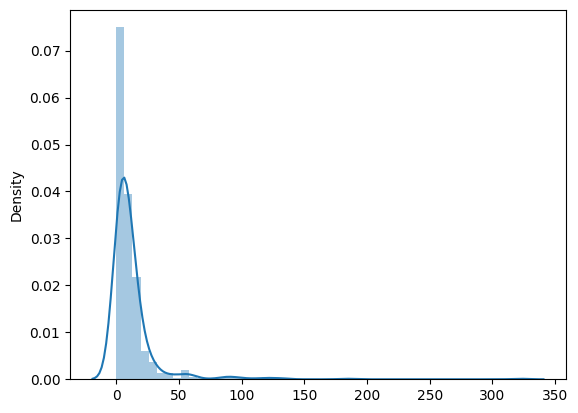

In [5]:
perm = []
sumIND = 0
sumPERM = 0
for i in permeationVStemperature:
    permeation = permeationVStemperature[i]['permeation']
    perm.append(permeation)
    sumPERM += permeationVStemperature[i]['permeation']
    sumIND += 1
    #sumPERM += permeationVStemperature[i]['SimLenght'] * permeationVStemperature[i]['permeation']
    #sumIND += permeationVStemperature[i]['SimLenght']
print(sumPERM/sumIND)

print(np.median(perm))

sns.distplot(perm)

#print(perm)
#perm.sort()
#for i in perm:
#    print(i)

# Plot permeation vs. area per lipid

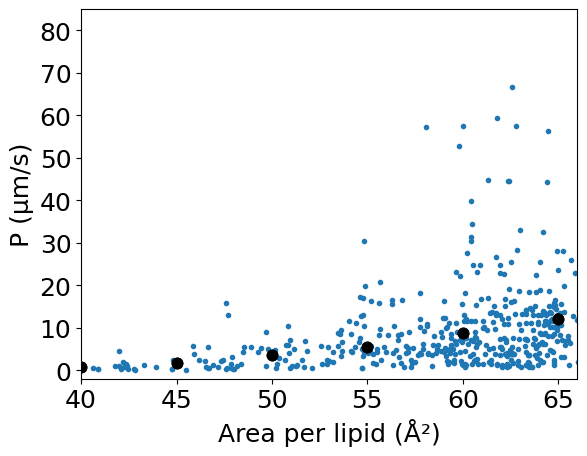

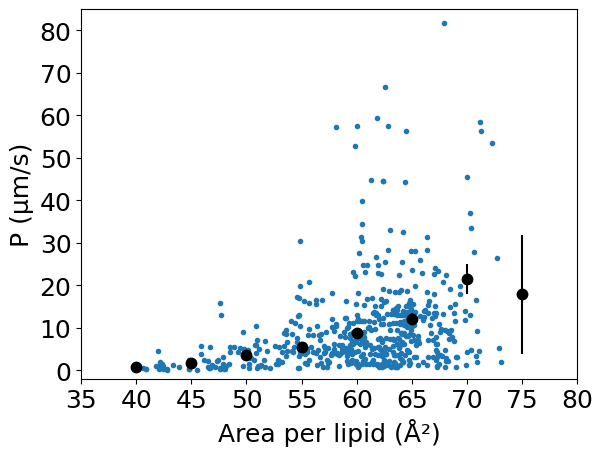

In [6]:
plotCorrelation('APL','permeation',permeationVStemperature)
result = plotXaveragedData('APL','permeation',permeationVStemperature,5,1000000)
plt.errorbar(result[0],result[1], yerr=result[2], marker = ".", linestyle='', markersize =15, color = 'black')
plt.xlabel('Area per lipid (Å²)', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('P (\u03bcm/s)', fontsize = 18)
plt.xlim([40,66])
#plt.ylim([-0.5,20])
plt.ylim([-2,85])
plt.savefig('../figures/APLvsPERMEATION.pdf')
plt.show()

plotCorrelation('APL','permeation',permeationVStemperature)
plt.errorbar(result[0],result[1], yerr=result[2], marker = ".", linestyle='', markersize =15, color = 'black')
plt.xlabel('Area per lipid (Å²)', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('P (\u03bcm/s)', fontsize = 18)
plt.xlim([35,80])
#plt.ylim([-0.5,20])
plt.ylim([-2,85])
plt.savefig('../figures/APLvsPERMEATIONzoomed.pdf')
plt.show()

# Plot permation vs. membrane thickness

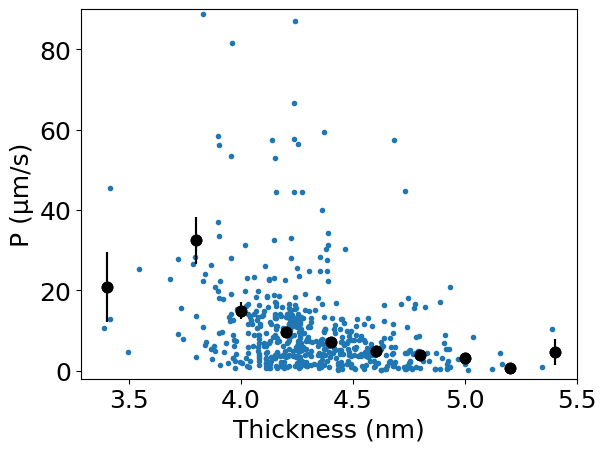

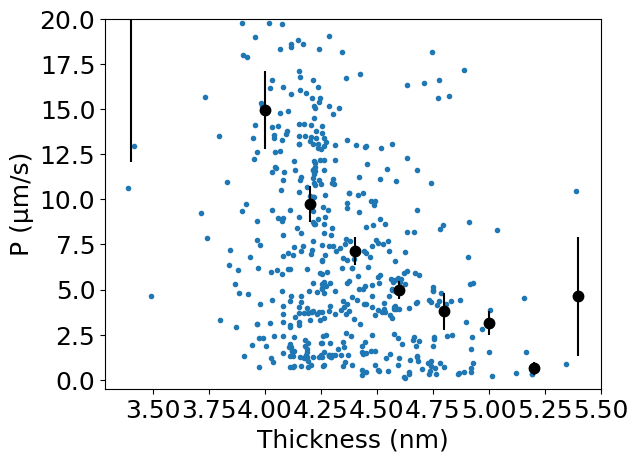

In [7]:
plotCorrelation('thickness','permeation',permeationVStemperature)
result = plotXaveragedData('thickness','permeation',permeationVStemperature,0.2,1000000)
plt.errorbar(result[0],result[1], yerr=result[2], marker = ".", linestyle='', markersize =15, color = 'black')
plt.xlabel('Thickness (nm)', fontsize = 18)
plt.xticks(np.arange(3.5, 5.51, step=0.5), fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('P (\u03bcm/s)', fontsize = 18)
#plt.xlim([3.3,5.6])
#plt.ylim([-0.5,20])
plt.ylim([-2,90])
plt.savefig('../figures/THICKNESSvsPERMEATION.pdf')
plt.show()

plotCorrelation('thickness','permeation',permeationVStemperature)
plt.errorbar(result[0],result[1], yerr=result[2], marker = ".", linestyle='', markersize =15, color = 'black')
plt.xlabel('Thickness (nm)', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('P (\u03bcm/s)', fontsize = 18)
#plt.xlim([3.95,5.4])
plt.ylim([-0.5,20])
#plt.ylim([-2,85])
plt.savefig('../figures/THICKNESSvsPERMEATIONzoomed.pdf')
plt.show()

#plt.xlim([3.95,5.3])
#plt.ylim([0,20])

# Plot permeation vs. temperature

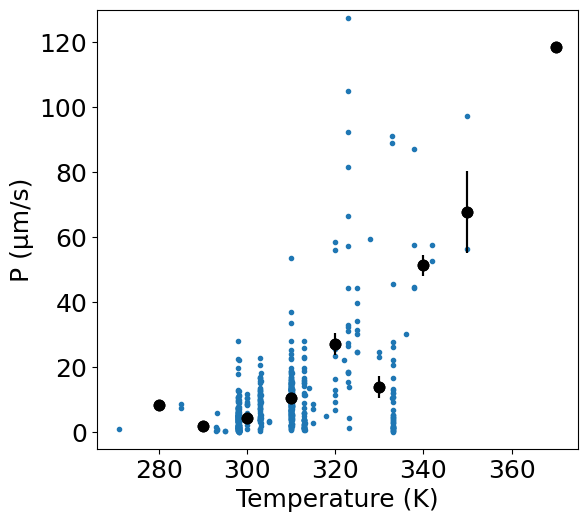

LinregressResult(slope=-4.1446980387036065, intercept=15.850381943134334, rvalue=-0.8934935190849146, pvalue=0.0011681647414474, stderr=0.7873582783296031, intercept_stderr=2.4791631978414874)
-4.1446980387036065
15.850381943134334
-0.8934935190849146
0.0011681647414474
0.7873582783296031


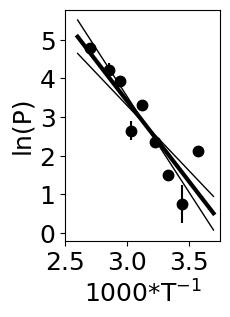

-13.908382680213444 2.6421418735892725


In [8]:
plt.rcParams['figure.figsize'] = [6.2, 5.7]
plotCorrelation('temperature','permeation',permeationVStemperature)
result = plotXaveragedData('temperature','permeation',permeationVStemperature,10,1000000)
#plt.ylim([-10,10])
plt.errorbar(result[0],result[1], yerr=result[2], marker = ".", linestyle='', markersize =15, color = 'black')
plt.xlabel('Temperature (K)', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('P (\u03bcm/s)', fontsize = 18)
#plt.xlim([40,66])
plt.ylim([-5,130])
plt.savefig('../figures/TEMPERATUREvsPERMEATION.pdf')
plt.show()

#plt.show()

itemp = []
logP = []
logPerror = []
for i in range(len(result[0])):
    itemp.append(1000*1/result[0][i])
    logP.append(np.log(result[1][i]))
    logPerror.append(result[2][i] / result[1][i])
    #plt.plot(1/results[0][i],np.log(results[1][i]),".")

plt.rcParams['figure.figsize'] = [2.0, 3.0]
plt.errorbar(itemp,logP, yerr=logPerror, marker = ".", linestyle='', markersize =15, color = 'black')
fitResult = scipy.stats.linregress(itemp, logP)
print(fitResult)
#slope, intercept, rvalue, pvalue, stderr, intercept_stderr = fitResult
#print(fitResult.intercept_stderr)
for i in fitResult:
    print(i)
#print(fitResult[4])
x = np.linspace(2.6,3.7,20)
plt.plot(x, fitResult[0]*x + fitResult[1], color = 'black', lw = 3)
plt.plot(x, (fitResult[0]-fitResult[4])*x + fitResult[1]+fitResult.intercept_stderr, color = 'black', lw = 1)
plt.plot(x, (fitResult[0]+fitResult[4])*x + fitResult[1]-fitResult.intercept_stderr, color = 'black', lw = 1)
plt.xlabel('1000*T$^{-1}$', fontsize = 18)
plt.xticks(np.arange(2.5, 3.7, step=0.5), fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('ln(P)', fontsize = 18)
plt.savefig('../figures/TEMPERATUREvsPERMEATIONafit.pdf')
plt.show()


print(1000*fitResult[0] / 298, 1000*fitResult[4] / 298)



# Plot permeation vs. tail order 

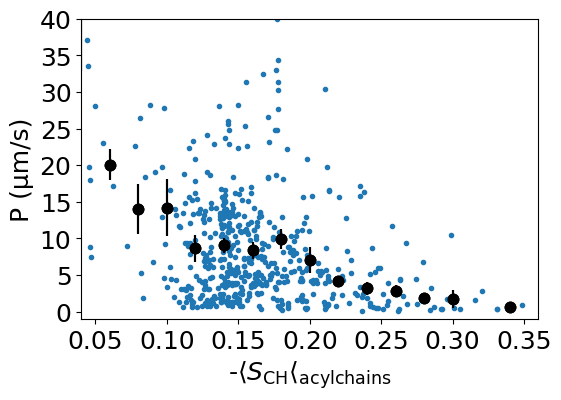

In [9]:
plt.rcParams['figure.figsize'] = [5.9, 3.9]
plotCorrelation('TailOrder','permeation',permeationVStemperature)
result = plotXaveragedData('TailOrder','permeation',permeationVStemperature,0.02,1000000)
plt.errorbar(result[0],result[1], yerr=result[2], marker = ".", linestyle='', markersize =15, color = 'black')
plt.ylim([-1,40])
#plt.xlabel('-$\langle $$\rangle$ ', fontsize = 18)
plt.xlabel('-$\langle S_\mathrm{CH}\langle_\mathrm{acyl chains}$', fontsize = 18)
#ax.set_xlabel('-$<$S$>_{acyl chains}$', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('P (\u03bcm/s)', fontsize = 18)
plt.xlim([0.04,0.36])
#plt.ylim([-0.5,20])
#plt.ylim([-2,85])
plt.savefig('../figures/CHAINORDERvsPERMEATION.pdf')
plt.show()


# Plot permeation vs. hydration or different lipid fractions

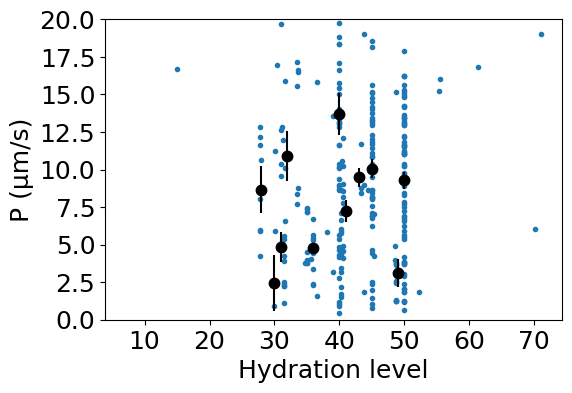

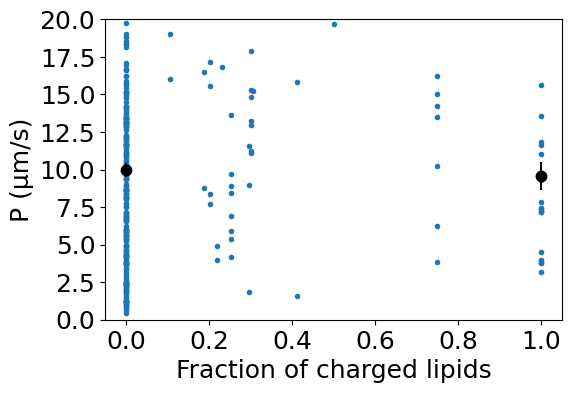

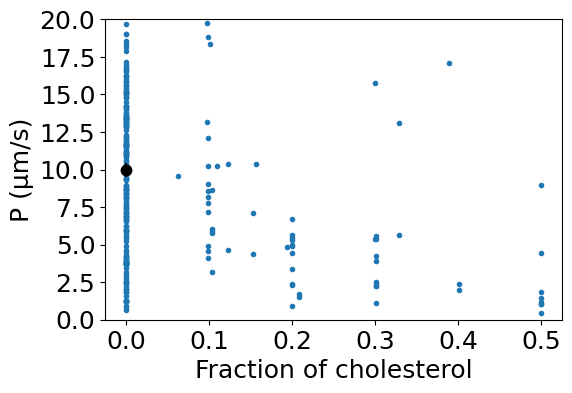

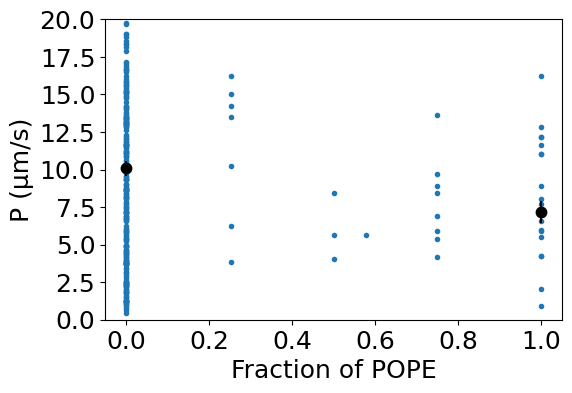

In [10]:
plotCorrelation('hydration','permeation',permeationVStemperatureFiltered)
result = plotXaveragedData('hydration','permeation',permeationVStemperatureFiltered,-1,1000000)
#plt.xticks(fontsize = 18)
#plt.yticks(fontsize = 18)
plt.xlabel('Hydration level', fontsize = 18)
plt.ylim([0,20])
plt.savefig('../figures/HYDRATIONvsPERMEATION.pdf')
plt.show()

plotCorrelation('ChargedFraction','permeation',permeationVStemperatureFiltered)
result = plotXaveragedData('ChargedFraction','permeation',permeationVStemperatureFiltered,1,1000000)
plt.xlabel('Fraction of charged lipids', fontsize = 18)
plt.ylim([0,20])
plt.savefig('../figures/CHARGEDvsPERMEATION.pdf')
plt.show()

plotCorrelation('CholFraction','permeation',permeationVStemperatureFiltered)
result = plotXaveragedData('CholFraction','permeation',permeationVStemperatureFiltered,1,1000000)
plt.xlabel('Fraction of cholesterol', fontsize = 18)
plt.ylim([0,20])
plt.savefig('../figures/CHOLESTEROLvsPERMEATION.pdf')
plt.show()

#plotCorrelation('POPGFraction','permeation',permeationVStemperatureFiltered)
#result = plotXaveragedData('POPGFraction','permeation',permeationVStemperatureFiltered,1)
#plt.ylim([0,20])
#plt.show()

#plotCorrelation('POPSFraction','permeation',permeationVStemperatureFiltered)
#result = plotXaveragedData('POPSFraction','permeation',permeationVStemperatureFiltered,1)
#plt.ylim([0,20])
#plt.show()

plotCorrelation('POPEFraction','permeation',permeationVStemperatureFiltered)
result = plotXaveragedData('POPEFraction','permeation',permeationVStemperatureFiltered,1,1000000)
plt.xlabel('Fraction of POPE', fontsize = 18)
plt.ylim([0,20])
plt.savefig('../figures/POPEvsPERMEATION.pdf')
plt.show()

# Plot translational diffusion vs. temperature

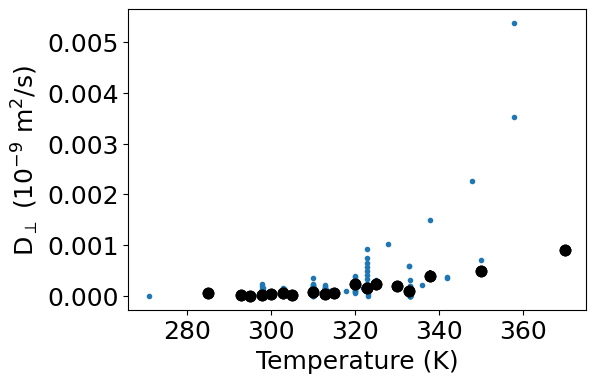

LinregressResult(slope=-5.464442729341642, intercept=-12.77820470790694, rvalue=-0.8414508868478835, pvalue=1.2055172241786303e-05, stderr=0.8772413479750559, intercept_stderr=2.784816015451754)
-5.464442729341642
-12.77820470790694
-0.8414508868478835
1.2055172241786303e-05
0.8772413479750559


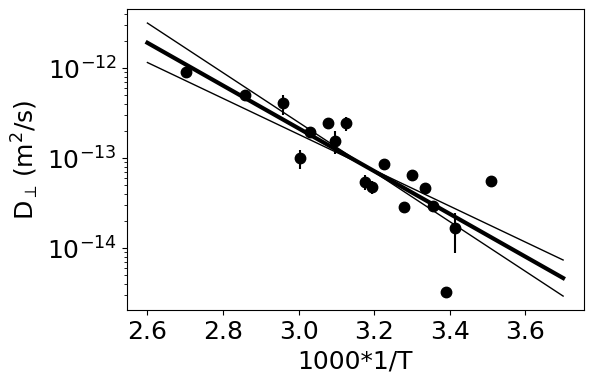

-18.337056138730343 2.9437629126679727


In [11]:
plotCorrelation('temperature','DiffThroughMem',permeationVStemperature)
result = plotXaveragedData('temperature','DiffThroughMem',permeationVStemperature,-1,1000000)
#plt.ylim([-10,10])
plt.errorbar(result[0],result[1], yerr=result[2], marker = ".", linestyle='', markersize =15, color = 'black')
plt.xlabel('Temperature (K)', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('D$_\perp$ (10$^{-9}$ m$^2$/s)', fontsize = 18)
#plt.xlim([40,66])
#plt.ylim([-5,130])
plt.savefig('../figures/TEMPERATUREvsTRANSDIFFUSION.pdf')
plt.show()

#plt.show()
    
itemp = []
logP = []
logPerror = []
P = []
Perror = []
for i in range(len(result[0])):
    itemp.append(1000*1/result[0][i])
    logP.append(math.log(result[1][i]*10**-9))
    P.append(result[1][i]*10**-9)
    logPerror.append(result[2][i] / result[1][i])
    Perror.append(result[2][i]*10**-9)
    

#plt.errorbar(itemp,logP, yerr=logPerror, marker = ".", linestyle='', markersize =15, color = 'black')
plt.errorbar(itemp,P, yerr=Perror, marker = ".", linestyle='', markersize =15, color = 'black')
fitResult = scipy.stats.linregress(itemp, logP)
print(fitResult)
#slope, intercept, rvalue, pvalue, stderr, intercept_stderr = fitResult
#print(fitResult.intercept_stderr)
for i in fitResult:
    print(i)
#print(fitResult[4])
x = np.linspace(2.6,3.7,20)
plt.plot(x, np.exp(fitResult[0]*x + fitResult[1]), color = 'black', lw = 3)
plt.plot(x, np.exp((fitResult[0]-fitResult[4])*x + fitResult[1]+fitResult.intercept_stderr), color = 'black', lw = 1)
plt.plot(x, np.exp((fitResult[0]+fitResult[4])*x + fitResult[1]-fitResult.intercept_stderr), color = 'black', lw = 1)
plt.xlabel('1000*1/T', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('D$_\perp\,(\mathrm{m}^2$/s)', fontsize = 18)
plt.yscale('log',base=10)
plt.savefig('../figures/TEMPERATUREvsTRANSDIFFUSIONfit.pdf')
plt.show()


print(1000*fitResult[0] / 298, 1000*fitResult[4] / 298)



# Water lateral diffusion as a function of temperature

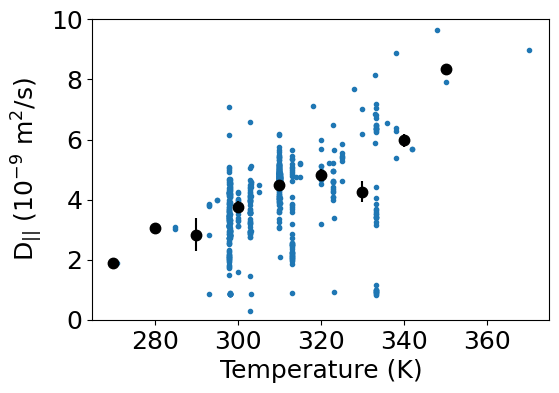

LinregressResult(slope=-1.600982601562691, intercept=-14.100031260430264, rvalue=-0.9631234211372353, pvalue=1.9710692046616235e-06, stderr=0.14908451180500804, intercept_stderr=0.47286496707362957)
-1.600982601562691
-14.100031260430264
-0.9631234211372353
1.9710692046616235e-06
0.14908451180500804


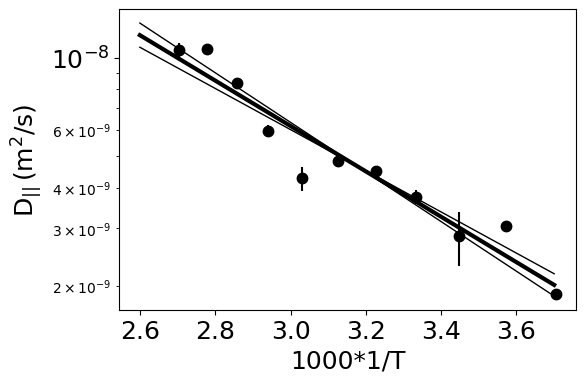

-5.372424837458694 0.5002835966611008


In [12]:
plt.rcParams['figure.figsize'] = [5.9, 3.9]
plotCorrelation('temperature','WaterLateralDiffusion',permeationVStemperature)
result = plotXaveragedData('temperature','WaterLateralDiffusion',permeationVStemperature,10,0)
plt.ylabel('D$_{||}$ (10$^{-9}$ m$^2$/s)', fontsize = 18)
plt.xlabel('Temperature (K)', fontsize = 18)
plt.ylim([-0,10])
plt.savefig('../figures/TEMPERATUREvsLATERALDIFFUSION.pdf')
plt.show()

itemp = []
logP = []
logPerror = []
P = []
Perror = []
for i in range(len(result[0])):
    itemp.append(1000*1/result[0][i])
    logP.append(math.log(result[1][i]*10**-9))
    P.append(result[1][i]*10**-9)
    logPerror.append(result[2][i] / result[1][i])
    Perror.append(result[2][i]*10**-9)
    #plt.plot(1/results[0][i],np.log(results[1][i]),".")

#plt.errorbar(itemp,logP, yerr=logPerror, marker = ".", linestyle='', markersize =15, color = 'black')
plt.errorbar(itemp,P, yerr=Perror, marker = ".", linestyle='', markersize =15, color = 'black')
fitResult = scipy.stats.linregress(itemp, logP)
print(fitResult)
#slope, intercept, rvalue, pvalue, stderr, intercept_stderr = fitResult
#print(fitResult.intercept_stderr)
for i in fitResult:
    print(i)
#print(fitResult[4])
x = np.linspace(2.6,3.7,20)
plt.plot(x, np.exp(fitResult[0]*x + fitResult[1]), color = 'black', lw = 3)
plt.plot(x, np.exp((fitResult[0]-fitResult[4])*x + fitResult[1]+fitResult.intercept_stderr), color = 'black', lw = 1)
plt.plot(x, np.exp((fitResult[0]+fitResult[4])*x + fitResult[1]-fitResult.intercept_stderr), color = 'black', lw = 1)
plt.xlabel('1000*1/T', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('D$_{||}\,(\mathrm{m}^2$/s)', fontsize = 18)
plt.yscale('log',base=10)
plt.savefig('../figures/TEMPERATUREvsLATERALDIFFUSIONfit.pdf')

# This is experimental data for bulk water diffusion

#ExpData_x = [3.005057471264368, 3.0533333333333332, 3.1006896551724137, 3.1498850574712645, 3.1995402298850575, 3.250574712643678, 3.3029885057471264, 3.359080459770115, 3.413793103448276]
#ExpData_y = [4.641588833612773e-9, 4.281332398719396e-9, 3.844105707405486e-9, 3.4983209357750324e-9, 3.1410584890748986e-9, 2.7825594022071257e-9, 2.5665913434124953e-9, 2.213243715758717e-9, 1.9606391068744616e-9]

#plt.plot(ExpData_x,ExpData_y,'.', markersize =15, color = 'red')
#fitResultExp = scipy.stats.linregress(ExpData_x, np.log(ExpData_y))
#plt.plot(x, np.exp(fitResultExp[0]*x + fitResultExp[1]), color = 'red', lw = 3)
##plt.plot(x, np.exp((fitResultExp[0]-fitResultExp[4])*x + fitResultExp[1]+fitResultExp.intercept_stderr), color = 'red', lw = 1)
##plt.plot(x, np.exp((fitResultExp[0]+fitResultExp[4])*x + fitResultExp[1]-fitResultExp.intercept_stderr), color = 'red', lw = 1)
##print(fitResultExp)

plt.show()


print(1000*fitResult[0] / 298, 1000*fitResult[4] / 298)
#print(1000*fitResultExp[0] / 298, 1000*fitResultExp[4] / 298)


# Water lateral diffusion as a function of hydration

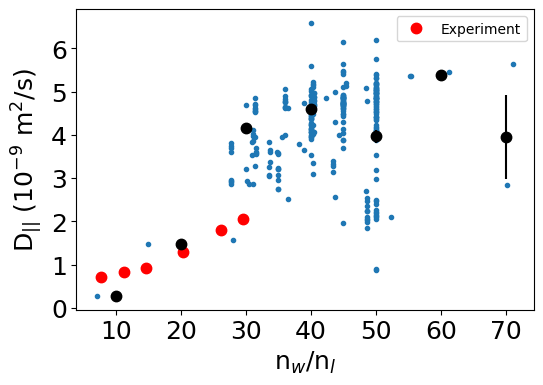

In [13]:
plotCorrelation('hydration','WaterLateralDiffusion',permeationVStemperatureFiltered)
result = plotXaveragedData('hydration','WaterLateralDiffusion',permeationVStemperatureFiltered,10,0)
plt.ylabel('D$_{||}$ (10$^{-9}$ m$^2$/s)', fontsize = 18)
plt.xlabel('n$_w$/n$_l$', fontsize = 18)
#plt.ylim([0,11])

ExperimentalData = [     #From Fig 3 a in https://doi.org/10.1007/BF03166747
    [17.04, 0.71],
    [22.97, 0.84],
    [27.93, 0.92],
    [35.00, 1.29],
    [40.99, 1.79],
    [43.98, 2.06]
]

def wtTOmolratio(wt):
    Mw = 18.015
    Ml = 677.9
    molratio = Ml/(Mw*(1/wt-1))
    return molratio

HydrationLevel = []
Diffusion = []
for i in ExperimentalData:
    HydrationLevel.append(wtTOmolratio(i[0]*0.01))
    MAfactor = np.sin(np.radians(54.7356))**2
    #Diffusion.append(i[1]/MAfactor)
    Diffusion.append(i[1])

plt.plot(HydrationLevel,Diffusion,'.',color='red', markersize =15, label = 'Experiment')
plt.legend()
#print(HydrationLevel,Diffusion)
plt.savefig('../figures/HYDRATIONvsLATERALDIFFUSION.pdf')

# Water lateral diffusion as a function of area per lipid, thickness, charged lipid fraction

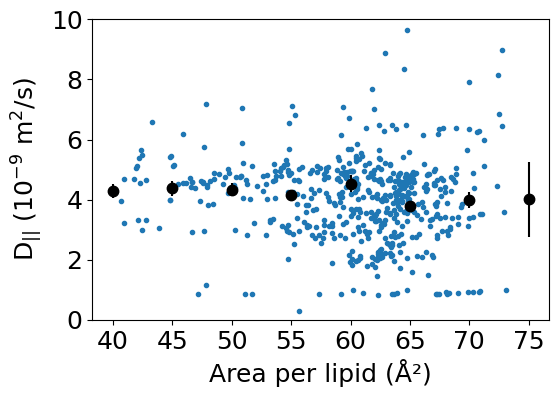

In [14]:
plt.rcParams['figure.figsize'] = [5.9, 3.9]
plotCorrelation('APL','WaterLateralDiffusion',permeationVStemperature)
result = plotXaveragedData('APL','WaterLateralDiffusion',permeationVStemperature,5,0)
plt.ylabel('D$_{||}$ (10$^{-9}$ m$^2$/s)', fontsize = 18)
plt.xlabel('Area per lipid (Å²)', fontsize = 18)
plt.ylim([-0,10])
plt.savefig('../figures/APLvsLATERALDIFFUSION.pdf')

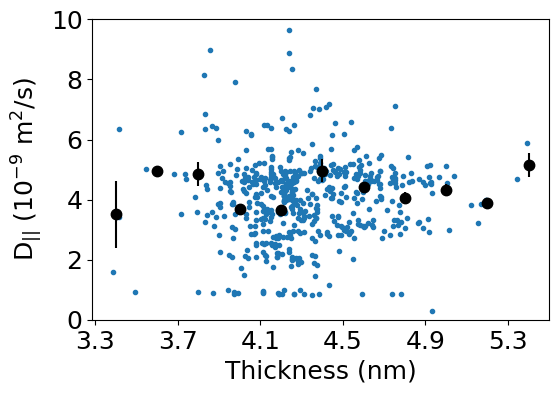

In [15]:
plt.rcParams['figure.figsize'] = [5.9, 3.9]
plotCorrelation('thickness','WaterLateralDiffusion',permeationVStemperature)
result = plotXaveragedData('thickness','WaterLateralDiffusion',permeationVStemperature,0.2,0)
plt.ylabel('D$_{||}$ (10$^{-9}$ m$^2$/s)', fontsize = 18)
plt.xticks(np.arange(3.3, 5.4, 0.4))
plt.xlabel('Thickness (nm)', fontsize = 18)
#plt.xlim([3.3,5.3])
plt.ylim([-0,10])
plt.savefig('../figures/THICKNESSvsLATERALDIFFUSION.pdf')

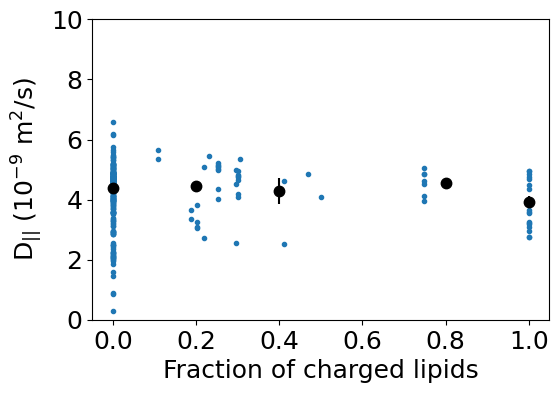

In [16]:
plotCorrelation('ChargedFraction','WaterLateralDiffusion',permeationVStemperatureFiltered)
result = plotXaveragedData('ChargedFraction','WaterLateralDiffusion',permeationVStemperatureFiltered,0.2,0)
plt.ylabel('D$_{||}$ (10$^{-9}$ m$^2$/s)', fontsize = 18)
#plt.xticks(np.arange(3.3, 5.4, 0.4))
plt.xlabel('Fraction of charged lipids', fontsize = 18)
#plt.xlim([3.3,5.3])
plt.ylim([-0,10])
plt.savefig('../figures/CHARGEDvsLATERALDIFFUSION.pdf')

# Diffusion anisotropy

(0.0, 0.0001)

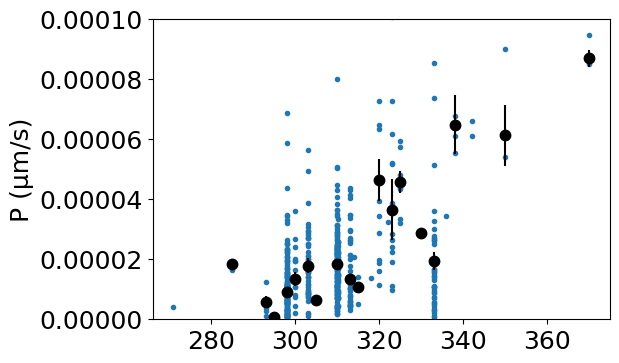

In [17]:
plotCorrelation('temperature','DiffAniso',permeationVStemperature)
result = plotXaveragedData('temperature','DiffAniso',permeationVStemperature,-1,1000000)
plt.ylim([0,0.0001])
#plt.xlim([3.8,5.3])

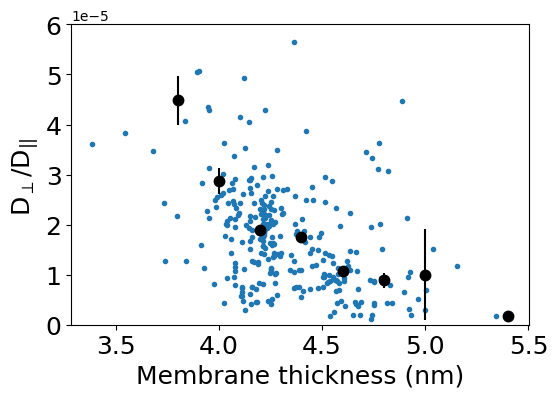

In [18]:
plotCorrelation('thickness','DiffAniso',permeationVStemperatureFiltered)
result = plotXaveragedData('thickness','DiffAniso',permeationVStemperatureFiltered,0.2,1000000)
plt.ylabel('D$_{\perp}$/D$_{||}$ ', fontsize = 18)
plt.xlabel('Membrane thickness (nm)', fontsize = 18)
plt.xticks(np.arange(3.5, 5.51, step=0.5), fontsize = 18)
plt.ylim([0,0.00006])
#plt.xlim([3.5,5.3])
plt.savefig('../figures/THICKNESSvsDIFFUSIONANISOT.pdf')

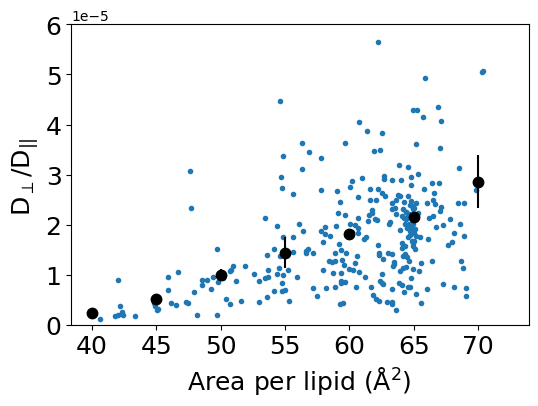

In [19]:
plotCorrelation('APL','DiffAniso',permeationVStemperatureFiltered)
result = plotXaveragedData('APL','DiffAniso',permeationVStemperatureFiltered,5,1000000)
plt.ylabel('D$_{\perp}$/D$_{||}$ ', fontsize = 18)
plt.xlabel('Area per lipid (Å$^2$) ', fontsize = 18)
plt.ylim([0,0.00006])
plt.savefig('../figures/APLvsDIFFUSIONANISOT.pdf')

(0.0, 6e-05)

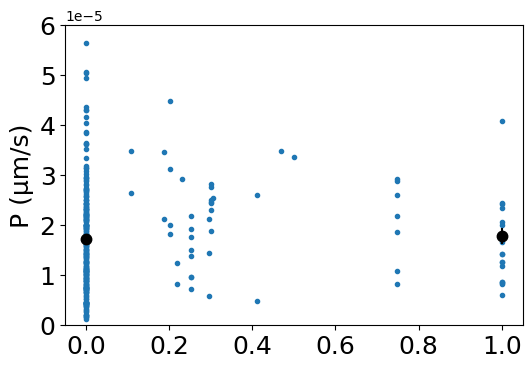

In [20]:
#print(permeationVStemperature)

plotCorrelation('ChargedFraction','DiffAniso',permeationVStemperatureFiltered)
result = plotXaveragedData('ChargedFraction','DiffAniso',permeationVStemperatureFiltered,1,1000000)
plt.ylim([0,0.00006])

(0.0, 6e-05)

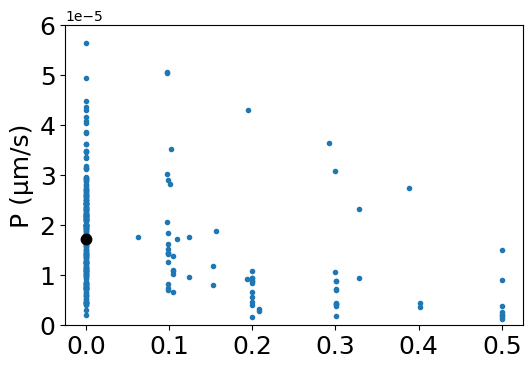

In [21]:
plotCorrelation('CholFraction','DiffAniso',permeationVStemperatureFiltered)
result = plotXaveragedData('CholFraction','DiffAniso',permeationVStemperatureFiltered,1,1000000)
plt.ylim([0,0.00006])

# Permation-diffusion ratio

(3.8, 5.3)

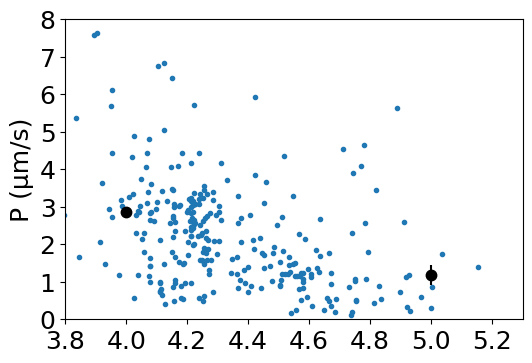

In [22]:
plotCorrelation('thickness','PermeationDiffusionRatio',permeationVStemperatureFiltered)
result = plotXaveragedData('thickness','PermeationDiffusionRatio',permeationVStemperatureFiltered,1,1000000)
plt.ylim([0,8])
plt.xlim([3.8,5.3])

(0.0, 8.0)

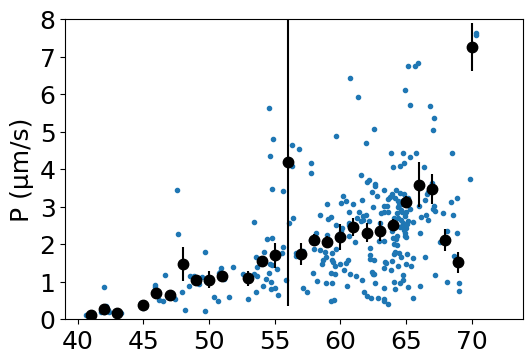

In [23]:
plotCorrelation('APL','PermeationDiffusionRatio',permeationVStemperatureFiltered)
result = plotXaveragedData('APL','PermeationDiffusionRatio',permeationVStemperatureFiltered,-1,1000000)
plt.ylim([0,8])
#plt.xlim([3.8,5.3])

# Area per lipid vs. thickness

ZeroDivisionError: float division by zero

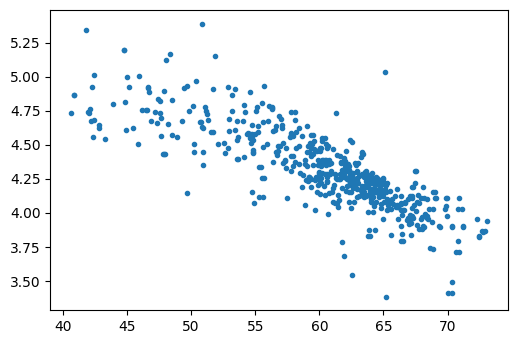

In [24]:
plotCorrelation('APL','thickness',permeationVStemperature)
result = plotXaveragedData('APL','thickness',permeationVStemperature,0,0)

In [ ]:
data = {}
for prop in permeationVStemperature[1]:
    if prop == 'path':
        continue
    data[prop] = []

for ID in permeationVStemperature:
    for prop in permeationVStemperature[ID]:
        if prop == 'path':
            continue
        data[prop].append(permeationVStemperature[ID][prop])
        #print(ID,prop)

columns = []
for i in data:
    columns.append(i)

df = pd.DataFrame(data,columns=columns)
#print (df)

In [ ]:
corrMatrix = df.corr()
#print (corrMatrix)
plt.figure(figsize = (20,10))
sn.heatmap(corrMatrix, annot=True)

plt.show()


In [ ]:
scipy.stats.pearsonr(data['ChargedFraction'],data['APL'])

In [ ]:
scipy.stats.spearmanr(data['ChargedFraction'],data['APL'])

In [ ]:
df

In [ ]:
from scipy import stats

def corrfunc(x, y, **kws):
  r, p = stats.pearsonr(x, y)
  p_stars = ''
  if p <= 0.05:
    p_stars = '*'
  if p <= 0.01:
    p_stars = '**'
  if p <= 0.001:
    p_stars = '***'
  ax = plt.gca()
  ax.annotate('r = {:.2f} '.format(r) + p_stars,
              xy=(0.05, 0.9), xycoords=ax.transAxes)


def annotate_colname(x, **kws):
  ax = plt.gca()
  ax.annotate(x.name, xy=(0.05, 0.9), xycoords=ax.transAxes,
              fontweight='bold')

g = sn.PairGrid(df, palette=['red'])
  # Use normal regplot as `lowess=True` doesn't provide CIs.
g.map_upper(sn.regplot, scatter_kws={'s':10})#, lowess = True)
g.map_diag(sn.histplot, kde= True)
g.map_diag(annotate_colname)
g.map_lower(sn.kdeplot, cmap='Blues_d')
g.map_lower(corrfunc)
# Remove axis labels, as they're in the diagonals.
for ax in g.axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')
g
g.figure.savefig("correlations.pdf")

In [ ]:
from scipy import stats

def corrfunc(x, y, **kws):
  #r, p = stats.pearsonr(x, y)
  r, p = stats.spearmanr(x, y)
  p_stars = ''
  if p <= 0.05:
    p_stars = '*'
  if p <= 0.01:
    p_stars = '**'
  if p <= 0.001:
    p_stars = '***'
  ax = plt.gca()
  ax.annotate('r = {:.2f} '.format(r) + p_stars,
              xy=(0.05, 0.9), xycoords=ax.transAxes)


def annotate_colname(x, **kws):
  ax = plt.gca()
  ax.annotate(x.name, xy=(0.05, 0.9), xycoords=ax.transAxes,
              fontweight='bold')

g = sn.PairGrid(df, palette=['red'])
  # Use normal regplot as `lowess=True` doesn't provide CIs.
g.map_upper(sn.regplot, scatter_kws={'s':10}, order = 1, robust = True ) #lowess = True)
g.map_diag(sn.histplot, kde= True)
g.map_diag(annotate_colname)
g.map_lower(sn.kdeplot, cmap='Blues_d')
g.map_lower(corrfunc)
# Remove axis labels, as they're in the diagonals.
for ax in g.axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')
g
g.figure.savefig("correlations.pdf")

In [ ]:
def CalcCorrCoeff(prop1,prop2):
    #prop1 = 'hydration'
    #prop2 = 'WaterLateralDiffusion'

    list1 = []
    list2 = []
    for ID in permeationVStemperature:
        #print(permeationVStemperature[ID])
        value1 = permeationVStemperature[ID][prop1]
        value2 = permeationVStemperature[ID][prop2]
        #if permeationVStemperature[ID][prop1] < 30:
        list1.append(value1)
        list2.append(value2)

    #print(stats.spearmanr(list1, list2))
    r, p = stats.pearsonr(list1, list2)

    p_stars = ''
    if p <= 0.05:
        p_stars = '*'
    if p <= 0.01:
        p_stars = '**'
    if p <= 0.001:
        p_stars = '***'
    
    ax = plt.gca()
    ax.annotate('r = {:.2f} '.format(r) + p_stars,
              xy=(0.05, 0.9), xycoords=ax.transAxes)

    sn.regplot(x=list1,y=list2, scatter_kws={'s':10})
    #return r, p_stars

plt.figure(figsize=(20,5))

properties = ['APL', 
             'thickness',
             # 'volume',
             'TailOrder',
             #'sn1Order',
             #'sn2Order',
             'hydration',
              'temperature',
              'ChargedFraction',
              'CholFraction',
              'POPGFraction',
              'POPSFraction',
              'POPEFraction'
             ]

for i in range(1,11):
    #print(i)
    
    plt.subplot(2, 10, i)
    plt.title(properties[i-1])
    if i == 1:
        plt.ylabel('Permeation')
    else:
        plt.yticks(color = 'w')
    CalcCorrCoeff(properties[i-1],'permeation')
    
    plt.subplot(2, 10, i+10)
    if i+10 == 11:
        plt.ylabel('Water lateral diffusion')
    else:
        plt.yticks(color = 'w')
    CalcCorrCoeff(properties[i-1],'WaterLateralDiffusion')

In [ ]:
plt.figure(figsize=(20,5))

properties = ['APL', 
             'thickness',
             'TailOrder',
             #'hydration',
              'temperature',
              #'ChargedFraction',
              #'CholFraction',
              #'POPGFraction',
              #'POPSFraction',
              #'POPEFraction'
             ]

for i in range(1,5):
    #print(i)
    
    plt.subplot(2, 7, i)
    plt.title(properties[i-1])
    if i == 1:
        plt.ylabel('Permeation')
    else:
        plt.yticks(color = 'w')
    CalcCorrCoeff(properties[i-1],'permeation')
    
    plt.subplot(2, 7, i+7)
    if i+7 == 8:
        plt.ylabel('Water lateral diffusion')
    else:
        plt.yticks(color = 'w')
    CalcCorrCoeff(properties[i-1],'WaterLateralDiffusion')
    
plt.savefig('PermDiffDep.pdf')

In [ ]:
def CalcCorrCoeffFilterHYD(prop1,prop2):
    #prop1 = 'hydration'
    #prop2 = 'WaterLateralDiffusion'

    list1 = []
    list2 = []
    for ID in permeationVStemperature:
        #print(permeationVStemperature[ID])
        value1 = permeationVStemperature[ID][prop1]
        value2 = permeationVStemperature[ID][prop2]
        if permeationVStemperature[ID]['hydration'] < 30:
            list1.append(value1)
            list2.append(value2)

    #print(stats.spearmanr(list1, list2))
    r, p = stats.pearsonr(list1, list2)

    p_stars = ''
    if p <= 0.05:
        p_stars = '*'
    if p <= 0.01:
        p_stars = '**'
    if p <= 0.001:
        p_stars = '***'
    
    ax = plt.gca()
    ax.annotate('r = {:.2f} '.format(r) + p_stars,
              xy=(0.05, 0.9), xycoords=ax.transAxes)

    sn.regplot(x=list1,y=list2, scatter_kws={'s':10})
    #return r, p_stars



plt.figure(figsize=(5,30))

properties = ['APL', 
             'thickness',
             'TailOrder',
              'WaterLateralDiffusion',
              'permeation'
             #'hydration',
             # 'temperature',
              #'ChargedFraction',
              #'CholFraction',
             #'POPGFraction',
             #'POPSFraction',
             #'POPEFraction'
             ]

for i in range(1,6):
    #print(i)
    
    plt.subplot(8, 1, i)
    if i ==1:
        plt.title('hydration')
    plt.ylabel(properties[i-1])
    #else:
    #    plt.yticks(color = 'w')
    CalcCorrCoeffFilterHYD('hydration',properties[i-1])
    
    #plt.subplot(2, 7, i+7)
    #if i+7 == 8:
    #    plt.ylabel('Water lateral diffusion')
    #else:
    #    plt.yticks(color = 'w')
    #CalcCorrCoeff(properties[i-1],'WaterLateralDiffusion')

In [ ]:
prop1 = 'APL'
prop2 = 'permeation'

list1 = []
list2 = []
for ID in permeationVStemperature:
    #print(permeationVStemperature[ID])
    value1 = permeationVStemperature[ID][prop1]
    value2 = permeationVStemperature[ID][prop2]
    if permeationVStemperature[ID]['permeation'] < 0.1:
        list1.append(value1)
        list2.append(value2)

#print(stats.spearmanr(list1, list2))
r, p = stats.pearsonr(list1, list2)

p_stars = ''
if p <= 0.05:
    p_stars = '*'
if p <= 0.01:
    p_stars = '**'
if p <= 0.001:
    p_stars = '***'
    
ax = plt.gca()
ax.annotate('r = {:.2f} '.format(r) + p_stars,
              xy=(0.05, 0.9), xycoords=ax.transAxes)

sn.regplot(x=list1,y=list2, scatter_kws={'s':10})#, order = 2)

In [ ]:
prop1 = 'thickness'
prop2 = 'permeation'

list1 = []
list2 = []
for ID in permeationVStemperature:
    #print(permeationVStemperature[ID])
    value1 = permeationVStemperature[ID][prop1]
    value2 = permeationVStemperature[ID][prop2]
    if permeationVStemperature[ID]['thickness'] > 3 and permeationVStemperature[ID]['permeation'] < 0.1:
        list1.append(value1)
        list2.append(value2)

#print(stats.spearmanr(list1, list2))
r, p = stats.pearsonr(list1, list2)

p_stars = ''
if p <= 0.05:
    p_stars = '*'
if p <= 0.01:
    p_stars = '**'
if p <= 0.001:
    p_stars = '***'
    
ax = plt.gca()
ax.annotate('r = {:.2f} '.format(r) + p_stars,
              xy=(0.05, 0.9), xycoords=ax.transAxes)

sn.regplot(x=list1,y=list2, scatter_kws={'s':10})#, order = 2)

In [ ]:
for i in range(1, 7):
    plt.subplot(2, 3, i)
    plt.text(0.5, 0.5, str((2, 3, i)),
             fontsize=18, ha='center')

In [ ]:
CHARMMsum = 0
CHARMMcount = 0
OTHERsum = 0
OTHERcount = 0


for i in permeationVStemperature:
    if permeationVStemperature[i]['temperature'] > 311:
        continue
    FF = permeationVStemperature[i]['ForceField']
    permeation = permeationVStemperature[i]['permeation']
    if 'CHARMM' in FF:
        CHARMMsum += permeation
        CHARMMcount += 1
    else:
        OTHERsum += permeation
        OTHERcount += 1
        
print(CHARMMsum/CHARMMcount, OTHERsum/OTHERcount)

In [ ]:
PermSum = 0
count = 0

for system in systems:
    try:
        rate = getWaterPermeationRate(system)
    except:
        continue
    
    POPCFraction = calcLipidFraction(system, 'POPC')
    if POPCFraction !=1:
        continue
        
    try:
        print(system['FF'],rate)
    except:
        continue
    
    if 'erger' in system['FF']:
        PermSum += rate
        count += 1
    else:
        continue

print(PermSum/count)

In [ ]:
def NagleFunct(x, a, g):
    iP = a*x[0]/(x[0]-48) + g*x[1]
    return iP

APLthick = []
permeation = []
for ID in permeationVStemperature:
    permeation.append(permeationVStemperature[ID]['permeation'])
    APLthick.append([permeationVStemperature[ID]['APL'], permeationVStemperature[ID]['thickness']])
    
scipy.optimize.curve_fit(NagleFunct, APLthick, permeation)

In [ ]:
len(APLthick)

#for i in APLthick:
#    print(NagleFunct(i,1,1))

In [ ]:
import numpy as np
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a*np.sin(x[0])+b*np.cos(x[1])+c

limits = [0, 2*np.pi, 0, 2*np.pi]  # [x1_min, x1_max, x2_min, x2_max]
side_x = np.linspace(limits[0], limits[1], 100)
side_y = np.linspace(limits[2], limits[3], 100)
X1, X2 = np.meshgrid(side_x, side_y)
size = X1.shape
x1_1d = X1.reshape((1, np.prod(size)))
x2_1d = X2.reshape((1, np.prod(size)))

xdata = np.vstack((x1_1d, x2_1d))
original = (3, 1, 0.5)
z = func(xdata, *original)
Z = z.reshape(size)
z_noise = z + .2*np.random.randn(len(z))
Z_noise = z_noise.reshape(size)

ydata = z_noise
popt, pcov = curve_fit(func, xdata, ydata)
print("original: {}\nfitted: {}".format(original, popt))
z_fit = func(xdata, *popt)
Z_fit = z_fit.reshape(size)

import matplotlib.pyplot as plt
plt.subplot(1, 3, 1)
plt.title("Real Function")
plt.pcolormesh(X1, X2, Z)
plt.axis(limits)
plt.colorbar()
plt.subplot(1, 3, 2)
plt.title("Function w/ Noise")
plt.pcolormesh(X1, X2, Z_noise)
plt.axis(limits)
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title("Fitted Function from Noisy One")
plt.pcolormesh(X1, X2, Z_fit)
plt.axis(limits)
plt.colorbar()

plt.show()

In [ ]:
xdata

In [ ]:
ydata

In [ ]:
tst = np.empty([0],[0])

In [ ]:
tst

In [ ]:
np.append([1],[1])

In [ ]:
def NagleFunct(x, a, g):
    #iP = a*x[0]/(x[0]-48) + g*x[1]
    #return 1/iP
    P = a*x[0] + g*x[1]
    return P
    

APL = []
thick = []
permeation = []
for ID in permeationVStemperature:
    permeation.append(permeationVStemperature[ID]['permeation'])
    APL.append(permeationVStemperature[ID]['APL'])
    thick.append(permeationVStemperature[ID]['thickness']*10)

x = np.asarray(APL)
y = np.asarray(thick)
X1, X2  = np.meshgrid(x,y)
#size = X1.shape
#x1_1d = X1.reshape((1, np.prod(size)))
#x2_1d = X2.reshape((1, np.prod(size)))
#xdata = np.vstack((X1, X2))
xdata = np.vstack((x, y))


ydata = np.asarray(permeation)
#ydata = ydata.reshape(size)

scipy.optimize.curve_fit(NagleFunct, xdata, ydata)

In [ ]:
xdata

In [ ]:
theo = []
sim = []
for i in range(len(APL)):
    theo.append(NagleFunct([APL[i],thick[i]], 0.38478557, -0.30789772))
    sim.append(permeation[i])
    #print(theo[i],sim[i])
plt.plot(theo,sim,".")
plt.ylim(0,20)
plt.xlim(0,20)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(len(APL)):
    ax.scatter(thick[i],APL[i],permeation[i])
#for angle in range(0, 360):

y = np.linspace(30, 60, 30)
x = np.linspace(50, 70, 30)

X, Y = np.meshgrid(x, y)
#Z = f(X, Y)
Z = NagleFunct((X,Y), 0.38478557, -0.30789772)

ax.contour3D(Y, X, Z, 50, cmap='binary')
ax.view_init(20, 20)
ax.set_zlim(0,20)
#plt.draw()
#plt.pause(.001)

In [ ]:
Y

In [ ]:
xmin, xmax, nx = -5, 4, 75
ymin, ymax, ny = -3, 7, 150
x, y = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(x, y)

In [ ]:
np.meshgrid(x, y)


In [ ]:
#xprop = 'temperature'
yprop = 'permeation'
#yprop = 'WaterLateralDiffusion'
xprop = 'thickness'

avetemp = {}
for ID in permeationVStemperature:
    #print(permeationVStemperature[ID])
    temperature = round(permeationVStemperature[ID][xprop], 1)
    if temperature not in avetemp.keys():
        avetemp[temperature] = {}
        avetemp[temperature]['values'] = []
        avetemp[temperature]['weigths'] = []
    avetemp[temperature]['values'].append(permeationVStemperature[ID][yprop])
    avetemp[temperature]['weigths'].append(permeationVStemperature[ID]['SimLenght']) 
    #print(permeationVStemperature[ID]['permeation'], permeationVStemperature[ID]['temperature'])
    
for temp in avetemp:
    average = np.average(avetemp[temp]['values'], weights = avetemp[temp]['weigths'])
    #plt.plot(1/temp, np.log(average),".")
    plt.plot(temp, average,".")

In [ ]:
avetemp

In [ ]:
mini= 100
for ID in permeationVStemperature:
    if permeationVStemperature[ID]['permeation'] > mini:
        mini = permeationVStemperature[ID]['permeation']
print(mini)